# Train Travel Comments Assessment

The objective of this task is to extract the topics that people are talking about and provide insights that help the client calibrate their internal strategy on how to improve
customer experience.

# Table of Contents

- [Data Exploration & Cleaning](#Data-Exploration-&-Cleaning)
- [Clustering](#Clustering)
  - [Used Functions](#Used-Functions)
  - [Positive Comments](#Positive)
    - [Company](#Company)
  - [Negative Comments](#Negative)
    - [Company](#Company)
- [Future Improvements](#Future-Improvements)
  - [Classifier](#Classifier)
  - [Other Improvements](#Other-Improvements)


In [ ]:
# # For running on google colab

# !pip install umap-learn
# !pip install hdbscan
# !pip install transformers
# !pip install sentence_transformers

In [53]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import umap
import hdbscan
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import torch
from torch import nn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments
from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dunja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


## Data Exploration & Cleaning

Data exploration and cleaning are critical steps in natural language processing (NLP). NLP deals with unstructured data, such as text, and this makes data exploration and cleaning even more important. Exploring the data allows us to gain insights into the structure of the data. It helps us identify any anomalies, inconsistencies or patterns that can impact the performance of our models. 

Some important things to look out for during these steps include:

1. Data completeness: Check if there are any missing values in the data, and determine the best way to handle them. This could involve imputing missing values or removing incomplete records altogether (empty comments)

2. Data bias: Be aware of any potential biases in the data that could impact the results of your NLP analysis (imbalanced star ratings)


In [2]:
# Load JSON file into a pandas DataFrame
with open('train_reviews.json') as f:
    df = pd.read_json(f)

In [3]:
df

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
...,...,...,...,...,...
2016,2017-07-06 20:20:58+00:00,Late,"Late, cancelled, signal failures, too much rai...",https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-1 star-rating--medium
2017,2016-11-29 10:26:41+00:00,Not sure why they even have timetables,Trains are constantly delayed or cancelled. I ...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-1 star-rating--medium
2018,2016-07-17 07:42:11+00:00,Helpful guards,On a yearly basis we take a group of Preschool...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-5 star-rating--medium
2019,2016-05-22 12:25:51+00:00,Often late but clean and decent.,I travel by them every day. I like their newis...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-3 star-rating--medium


We can gain useful insights from every column in our dataset:

1. Company Name: We can extract the name of the railway company from the URL column. Since the URLs have a specific structure, we can extract the relevant information using regular expressions.

2. Star Ratings: We can also extract the star ratings given by the customers using regular expressions. This will help us understand the overall sentiment of the customers towards the railway companies.

3. Year: We can extract the year from the date column, as other parts of the date are less relevant for our analysis.

4. Concatenation of Title and Text Columns: We can concatenate the title and text columns to gain even more information about the comments made by the customers. This will help us understand the specific areas of improvement that the railway companies need to focus on.

In [4]:
df['url'] = df['url'].apply(lambda x: re.sub(r"^.{37}|\..*", "", x))
df['stars'] = df['stars'].apply(lambda x: int(re.search(r'\d+', x).group()))
df['year'] = df['date'].dt.year
df['text'] = df['title'] + ' ' + df['text']
df = df.drop('date',axis=1)
df


,title,text,url,stars,year
0,Bad customer service. Staff are very impolite ...,Bad customer service. Staff are very impolite ...,nationalrail,1,2015
1,Pretty awful service,Pretty awful service I phoned National rail to...,nationalrail,1,2015
2,Awful staff,Awful staff I travel from Brokenhast to southa...,nationalrail,1,2015
3,Very good,Very good Saved about £50 on a single trip usi...,nationalrail,4,2015
4,Check it out.,Check it out. I always use the national rail e...,nationalrail,4,2011
...,...,...,...,...,...
2016,Late,"Late Late, cancelled, signal failures, too muc...",southeasternrailway,1,2017
2017,Not sure why they even have timetables,Not sure why they even have timetables Trains ...,southeasternrailway,1,2016
2018,Helpful guards,Helpful guards On a yearly basis we take a gro...,southeasternrailway,5,2016
2019,Often late but clean and decent.,Often late but clean and decent. I travel by t...,southeasternrailway,3,2016


In [5]:
# Checking for empty comments

df = df[df['text'].astype(bool)]
df

,title,text,url,stars,year
0,Bad customer service. Staff are very impolite ...,Bad customer service. Staff are very impolite ...,nationalrail,1,2015
1,Pretty awful service,Pretty awful service I phoned National rail to...,nationalrail,1,2015
2,Awful staff,Awful staff I travel from Brokenhast to southa...,nationalrail,1,2015
3,Very good,Very good Saved about £50 on a single trip usi...,nationalrail,4,2015
4,Check it out.,Check it out. I always use the national rail e...,nationalrail,4,2011
...,...,...,...,...,...
2016,Late,"Late Late, cancelled, signal failures, too muc...",southeasternrailway,1,2017
2017,Not sure why they even have timetables,Not sure why they even have timetables Trains ...,southeasternrailway,1,2016
2018,Helpful guards,Helpful guards On a yearly basis we take a gro...,southeasternrailway,5,2016
2019,Often late but clean and decent.,Often late but clean and decent. I travel by t...,southeasternrailway,3,2016


In [6]:
# Checking for unique rows
num_unique = df['text'].nunique()
num_unique

1439

In [7]:
duplicated_indices = df[df['text'].duplicated(keep=False)].index

# Print out the rows with non-unique values in the column
df.loc[duplicated_indices].sort_values(by='text')

,title,text,url,stars,year
1417,180 for a ticket and stood for 7 hours,180 for a ticket and stood for 7 hours Paid 18...,virgintrains,1,2018
650,180 for a ticket and stood for 7 hours,180 for a ticket and stood for 7 hours Paid 18...,virgintrains,1,2018
1749,1st.July Sunday 11.30 Salisbury to…,1st.July Sunday 11.30 Salisbury to… 1st.July ...,gwr,1,2018
1889,1st.July Sunday 11.30 Salisbury to…,1st.July Sunday 11.30 Salisbury to… 1st.July ...,gwr,1,2018
1887,A Third World service but at inflated cost,A Third World service but at inflated cost The...,gwr,1,2018
...,...,...,...,...,...
1885,well the start of another journey from…,well the start of another journey from… well t...,gwr,1,2018
1111,worst ride ever,worst ride ever worst ride ever. All my trains...,virgintrainseastcoast,1,2018
1003,worst ride ever,worst ride ever worst ride ever. All my trains...,virgintrainseastcoast,1,2018
411,£180 to be shipped like cattle,£180 to be shipped like cattle No option to re...,eastmidlandstrains,2,2017


In [8]:
# Dropping duplicate rows as they can lead us to wrong insights
df = df.drop_duplicates(subset=['text'])
df

,title,text,url,stars,year
0,Bad customer service. Staff are very impolite ...,Bad customer service. Staff are very impolite ...,nationalrail,1,2015
1,Pretty awful service,Pretty awful service I phoned National rail to...,nationalrail,1,2015
2,Awful staff,Awful staff I travel from Brokenhast to southa...,nationalrail,1,2015
3,Very good,Very good Saved about £50 on a single trip usi...,nationalrail,4,2015
4,Check it out.,Check it out. I always use the national rail e...,nationalrail,4,2011
...,...,...,...,...,...
2016,Late,"Late Late, cancelled, signal failures, too muc...",southeasternrailway,1,2017
2017,Not sure why they even have timetables,Not sure why they even have timetables Trains ...,southeasternrailway,1,2016
2018,Helpful guards,Helpful guards On a yearly basis we take a gro...,southeasternrailway,5,2016
2019,Often late but clean and decent.,Often late but clean and decent. I travel by t...,southeasternrailway,3,2016


<AxesSubplot:title={'center':'Number of Comments per Year'}>

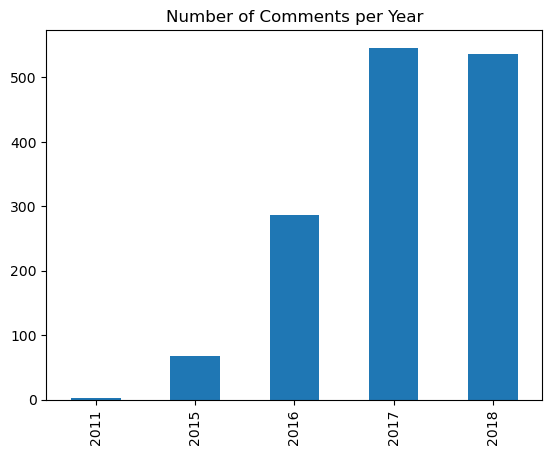

In [9]:
# Get the count of comments per year
count_per_year = df['year'].value_counts()

# Sort the counts by year
count_per_year = count_per_year.sort_index()

# Plot the count of comments per year
count_per_year.plot(kind='bar', title='Number of Comments per Year')

In [10]:
# Removing all comments made before 2016, as they may not be relevant anymore
df = df[df['year'] > 2015]

By looking at the number of comments per company, we can see which company people talk about/use the most.

<AxesSubplot:title={'center':'Number of Comments per Company'}>

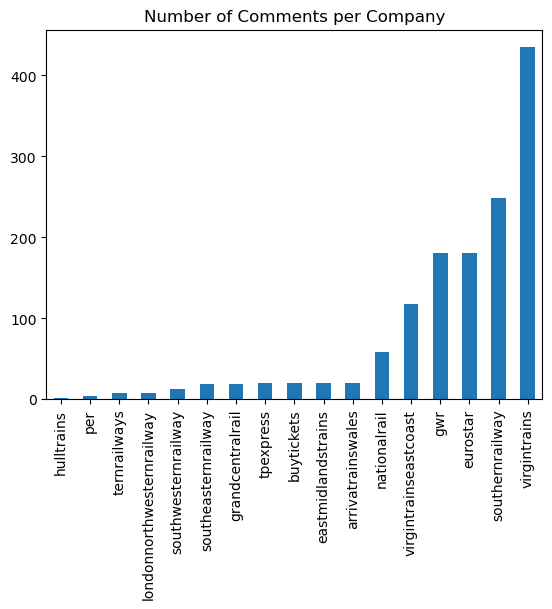

In [63]:
# Get the count of comments per company
count_per_company = df['url'].value_counts().sort_values()

# Plot the count of comments per company
count_per_company.plot(kind='bar', title='Number of Comments per Company')

In our analysis of the dataset, we observed the average ratings for each railway company. The results indicate that the majority of the ratings are low, with one notable exception. Hull Trains stands out with a significantly higher rating than the other companies. However, it is important to note that the number of comments for this company is relatively low, which may skew the results. Therefore, we cannot definitively conclude that Hull Trains is better than the other companies based solely on its rating. Further analysis and data collection would be necessary to confirm this.

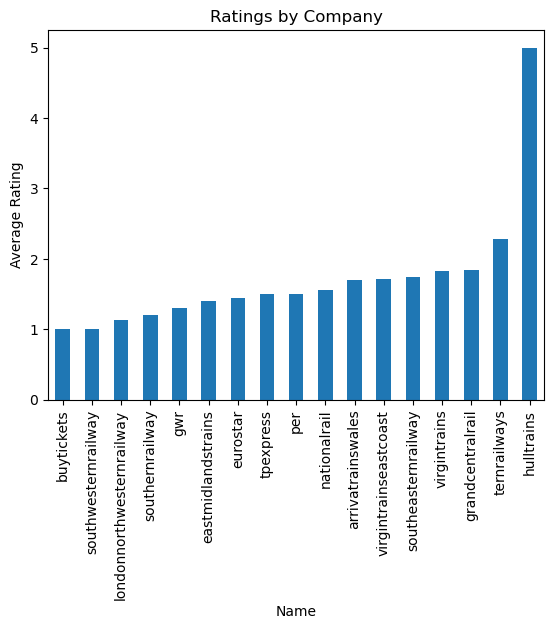

In [65]:

# Group the ratings by name and calculate the average rating for each name
ratings_by_name = df.groupby('url')['stars'].mean().sort_values()

# Plot a bar graph of the ratings by company
ratings_by_name.plot(kind='bar')

# Add labels and title to the plot
plt.xlabel('Name')
plt.ylabel('Average Rating')
plt.title('Ratings by Company')

# Display the plot
plt.show()

Examining the rating distribution is a crucial step in analyzing the dataset, as it can provide valuable insights into the overall sentiment of the customers towards the railway companies. In this case, we can observe that the majority of comments have a one-star rating, indicating a high level of dissatisfaction among the customers. This also highlights the imbalanced nature of the dataset, where the negative ratings significantly outnumber the positive ones.

<AxesSubplot:title={'center':'Number of Comments per Star Rating'}>

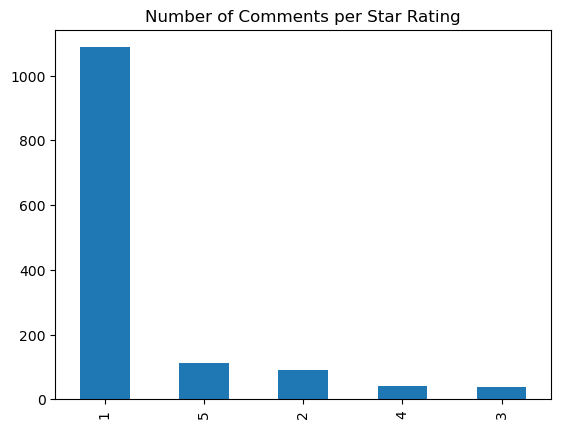

In [69]:
# Get the count of comments per company
count_per_company = df['stars'].value_counts()


# Plot the count of comments per company
count_per_company.plot(kind='bar', title='Number of Comments per Star Rating')

To better analyze the sentiments expressed in the dataset, it makes sense to divide the ratings into positive and negative sentiments, given the imbalanced nature of the rating distribution and the focus of the task at hand. Specifically, the main objective is to see customer sentiment towards the train schedules, and this approach will provide a clearer picture of the overall sentiment.

In [13]:
# Divide into positive and negative
# Everything with more than 3 stars is considered positive, and vice versa
df_positive = df[df['stars'] > 3] 
df_negative = df[df['stars'] < 4]

In [14]:
df_positive

,title,text,url,stars,year
11,Left phone on train..,Left phone on train.. Left phone on train... n...,nationalrail,5,2018
21,Just received the most outstanding …,Just received the most outstanding … Just rece...,nationalrail,5,2017
31,I have recently visited the UK from …Australia,I have recently visited the UK from …Australia...,nationalrail,5,2017
43,No complaints,No complaints We used National Rail extensivel...,nationalrail,5,2016
53,Disabled assistance,Disabled assistance Today I have travelled by ...,nationalrail,5,2018
...,...,...,...,...,...
1949,Great service and comfortable trains.,Great service and comfortable trains. Great se...,hulltrains,5,2018
1956,On Thursday 1 March and travelling from…,On Thursday 1 March and travelling from… On Th...,tpexpress,5,2018
1957,Clean trains with conductors going …,Clean trains with conductors going … Clean tra...,tpexpress,5,2018
2005,Exceptional service from Rochester staff.,Exceptional service from Rochester staff. On a...,southeasternrailway,5,2018


In [15]:
df_negative

,title,text,url,stars,year
5,Oh no! There is always a problem!,Oh no! There is always a problem! The website ...,nationalrail,1,2018
6,Terrible communication from staff st…,Terrible communication from staff st… Terrible...,nationalrail,1,2018
7,Cancellations due to heavy snow? It’s not snowin!,Cancellations due to heavy snow? It’s not snow...,nationalrail,1,2018
8,The Worst Company In Britain,The Worst Company In Britain National rail is ...,nationalrail,1,2018
9,Christmas got cancelled - no refund,Christmas got cancelled - no refund Worst cust...,nationalrail,1,2018
...,...,...,...,...,...
2014,Why can’t something be done about this …,Why can’t something be done about this … Why c...,southeasternrailway,1,2017
2015,Don't buy a senior railcard a nasty company wi...,Don't buy a senior railcard a nasty company wi...,southeasternrailway,1,2017
2016,Late,"Late Late, cancelled, signal failures, too muc...",southeasternrailway,1,2017
2017,Not sure why they even have timetables,Not sure why they even have timetables Trains ...,southeasternrailway,1,2016


# Clustering

Clustering is a common technique used in topic modeling to group together similar documents based on their content. The goal of clustering is to identify topics or themes that emerge from the documents and group them into meaningful categories. Clustering algorithms use various similarity measures to compare the documents and group them based on their content. Once the documents are clustered, we can examine the topics that emerge within each cluster to gain insights into the underlying themes and patterns in the data. 

In this case, we have divided the comments into positive and negative sentiments. This approach allows us to identify the main issues that people have highlighted in the negative comments. Furthermore, it also helps us identify what people like, which can be helpful in improving the service.

### Used Functions

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique used in machine learning and data science. UMAP is similar to t-SNE (t-Distributed Stochastic Neighbor Embedding), but with some key differences. UMAP is faster and more scalable, and it can handle larger datasets. It also has better preservation of the global structure of the data. UMAP works by modeling the topological structure of the data, and projecting it onto a lower-dimensional space. This makes it useful for visualizing high-dimensional data and identifying clusters or patterns within it. In this case, UMAP is used to reduce the dimensionality of word embeddings and to cluster words based on their semantic similarity.

In [16]:
def umap_f(embeddings, n_neighbors=15, n_components=5):
   
    umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                random_state=42,
                                metric='cosine').fit_transform(embeddings.cpu())
    return umap_embeddings

HDBSCAN is a density-based clustering algorithm that can identify clusters of arbitrary shapes and sizes in high-dimensional data. It works by building a hierarchical tree of clusters based on the density of points, where the density of a cluster is defined as the minimum density required for a point to be considered a core point of the cluster. The algorithm starts by identifying core points, which are points with a sufficient number of neighboring points within a specified radius. Then, non-core points are assigned to nearby clusters or treated as noise. The result is a clustering that can handle outliers and noise, and can identify clusters of different shapes and sizes. 

In [17]:
def hdbscan_f(embeddings, min_cluster_size=15, min_samples=2):

    cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                            min_samples=min_samples,
                            metric='euclidean',                      
                            cluster_selection_method='eom').fit(embeddings)
    return cluster


SentenceTransformer('all-MiniLM-L6-v2') is a pre-trained transformer-based model developed by the Hugging Face team. It uses the MiniLM-L6 architecture, which is a smaller and faster variant of the popular BERT model, while still providing high-quality language representations. The 'all' in the model name indicates that it has been trained on a large and diverse collection of text data, which includes Wikipedia, books, news articles, and scientific publications. This allows the model to capture a wide range of language patterns and nuances, making it suitable for a variety of natural language processing tasks. In this task, we use it for obtaining high-quality sentence embeddings.

The summarization pipeline in the Hugging Face Transformers library is a powerful tool for generating text summaries of longer documents or articles. It is based on pre-trained transformer models that are fine-tuned on summarization tasks. The pipeline takes in the input text and returns a summarized version, where the length of the summary can be controlled by adjusting the "max_length" parameter. The pipeline uses the transformer's attention mechanism to assign weights to the most important sentences or phrases in the input text, allowing it to capture the main ideas and concepts. 

The default model used in our system is the sshleifer/distilbart-cnn-12-6, a top-performing pre-trained sequence-to-sequence model based on the popular BART architecture. This particular variant of the model was fine-tuned on a large dataset of news articles and their corresponding summaries, making it ideal for abstractive text summarization. With this approach, the model generates summaries that are not mere extracts from the input text, but rather a condensed version that captures the most important information. The "distil" prefix in the model name indicates that it is a lighter and faster version of the full BART model, without sacrificing much of its performance.

In [18]:
# Model for computing sentence embeddings, we use one trained for similar questions detection
model = SentenceTransformer('all-MiniLM-L6-v2')
# Transformers pipeline for text summarization
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
# Function for visualizing clusters in 2D

def visualize_clusters(corpus_embeddings, n_neighbors, cluster):

    umap_data = umap_f(corpus_embeddings, n_neighbors=n_neighbors, n_components=2)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(10, 5))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]

    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1.5)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')
    plt.colorbar()  

c-TF-IDF (Class-based Term Frequency-Inverse Document Frequency) is a variation of the classic TF-IDF algorithm that takes into account the class information of each document. In this case, classes are represented by clusters and documents are concatenated comments that belong to a certain cluster. This algorithm considers each document as a sample from a certain class and calculates the TF-IDF weights for each term separately for each class. This allows the algorithm to identify the most important terms for each class and differentiate them from those that are not significant for that class. The output of c-TF-IDF is a matrix of TF-IDF weights where each row represents a document and each column represents a term, weighted by its importance for that particular document's class.

In [20]:

# Convert a collection of text documents into a matrix of token counts
# Create a vocabulary of unique words from the text corpus and assign an index to each word
# Count the frequency of each word in each document
# Return a matrix where each row represents a document and each column represents a word in the vocabulary, with the count of that word in that document

def c_tf_idf(documents, m, ngram_range=(1, 1)):
        
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents) # stop words are removed
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  

In [29]:
# Get the feature names (words) from the count object 
# Gets the topic labels from the docs_per_topic DataFrame
# Transposes the tf_idf matrix so that the rows correspond to words and the columns correspond to documents
# Apply the argsort method to each row of the transposed matrix to get the indices of the top n words in descending order of importance
# Uses these indices to get the corresponding words and their importance scores for each topic label
# Returns a dictionary where the keys are the topic labels and the values are lists of the top n words and their importance scores for each topic.

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [words[j] for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes


In [70]:
# Tokenize sentences of each topic (concatenated comments) 
# Look for sentences that contain any of the top words
# Create summaries using only found sentences
# Return a resulting DataFrame with the topic, size, top words, and comment summaries

def generate_results(df, top_n_words, topic_sizes, company=False):

    result_df = pd.DataFrame(columns=['topic', 'size', 'top_words', 'comment_summary'])
    print('Generating resulting DataFrame may take time')

    for index, row in df.iterrows():

        sents = row['text']

        if company:     
            topic_top_words = top_n_words[topic_sizes['topic'][index]]
            topic_name = topic_sizes['topic'][index] 
        else:
            topic_top_words = top_n_words[index-1]
            topic_name = index-1

        topic_size = topic_sizes['size'][index]
        
        # Tokenize the text into sentences
        sentences = nltk.sent_tokenize(sents)

        # Loop over each sentence
        sentences_containing_words = []
        for sentence in sentences:
            # Tokenize the sentence into words
            words = nltk.word_tokenize(sentence)
            # Check if any of the words are in the set of certain words
            if any(word.lower() in topic_top_words for word in words):
                # If so, add the sentence to the list of sentences containing certain words
                sentences_containing_words.append(sentence)

        # Combine the sentences into a single string
        combined_sentences = ' '.join(sentences_containing_words)

        comment_summary = summarizer(combined_sentences[:2000], min_length=100, max_length=150)[0]['summary_text']

        result_df = result_df.append({'topic': topic_name, 'size': topic_size, 'top_words': topic_top_words, 'comment_summary': comment_summary}, ignore_index=True)


    return result_df

In [31]:
# Print a certain number of examples from a DataFrame for better comprehension

def show_examples(result_df, index):
    if index>result_df.shape[0]:
        print(f'Index ({index}) larger than number of rows ({result_df.shape[0]})')
        return
    for i, row in result_df.iterrows():
        print(f'Company: {row.topic}')
        print(f'Top words: {row.top_words}')
        print(f'Comment summary: {row.comment_summary}')
        print()

        if i==index:
            break

In [32]:
# Create a DataFrame consisting of topics and concatenated comments that fall under that topic

def create_docs_per_topic(df, cluster):
    docs_df = pd.DataFrame(df, columns=["text"])
    docs_df['topic'] =  cluster.labels_
    neg_docs_per_topic = docs_df.groupby(['topic'], as_index = False).agg({'text': ' '.join})
    
    return docs_df, neg_docs_per_topic


## Positive Comments

In [33]:
# Obtaining text embeddings for positive comments
positive_comments = list(df_positive['text'])
positive_embeddings = model.encode(positive_comments, batch_size=32, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
# Dimension reduction using umap and clustering using hdbscan
positive_umap_embeddings = umap_f(positive_embeddings)
positive_cluster = hdbscan_f(positive_umap_embeddings, min_cluster_size=2, min_samples=2)

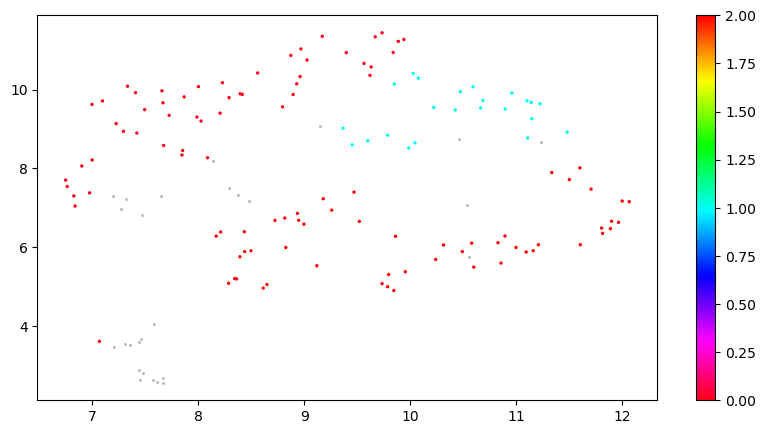

In [35]:
visualize_clusters(positive_embeddings, 5, positive_cluster)

By sorting the topic sizes from largest to smallest, we allow the customer to quickly identify the most prevalent topics in the dataset. This information can be extremely useful in identifying areas where improvements are needed or in better understanding the underlying trends and patterns in the data. Additionally, the inclusion of the -1 topic category for comments that do not belong in any specific cluster helps ensure that all comments are accounted for and not left out of the analysis.

In [36]:
# Obtaining the top words for each topic using c-tf-idf and calculating the sizes
pos_docs_df, pos_docs_per_topic = create_docs_per_topic(df_positive, positive_cluster)
pos_tf_idf, pos_count = c_tf_idf(pos_docs_per_topic.text.values, m=len(df_positive))
pos_top_n_words = extract_top_n_words_per_topic(pos_tf_idf, pos_count, pos_docs_per_topic, n=10)
pos_topic_sizes = extract_topic_sizes(pos_docs_df)
pos_topic_sizes.head(10)

,topic,size
3,2,52
1,0,50
0,-1,27
2,1,23


The generated Dataframe from the comments analysis provides a comprehensive overview of the most common words used and their corresponding topics. To aid in topic understanding, comment summaries are also included. The top words are sorted in descending order of importance, with the most significant words appearing at the top of the list. This DataFrame can be exported in multiple formats, such as JSON or CSV, making it easy to use in future analyses or to be stored as an archive. The availability of this resourceful and easily exportable DataFrame can aid in making informed decisions and implementing necessary changes to improve the customer experience.

In [55]:
pos_result_df = generate_results(pos_docs_per_topic, pos_top_n_words, pos_topic_sizes)
pos_result_df

Generating resulting DataFrame may take time


,topic,size,top_words,comment_summary
0,-1,27,"[eurostar, paris, coffee, brussels, pancras, l...",I have recently visited the UK from Australia...
1,0,50,"[virgin, manager, euston, trains, liverpool, g...",Staff were so lovely on the virgin train that...
2,1,23,"[use, good, clean, delays, website, usually, t...","I use the app daily, I just wish that the app..."
3,2,52,"[class, thank, newcastle, excellent, edinburgh...",The customer service is absolutely first clas...


By analyzing the topics and comments in our dataset, we can gain valuable insights into the opinions and experiences of customers. Upon closer inspection, we can observe that topic 0 is dedicated to the Virgin train company and its positive aspects, such as affordable fares and exceptional staff. Topic 1 centers around website services, while topic 2 is associated with excellent customer service. Understanding these topics can help train companies to focus on improving areas that are important to their customers and potentially gain a competitive advantage.

In [38]:
show_examples(pos_result_df, 3) 

Company: -1
Top words: ['eurostar', 'paris', 'coffee', 'brussels', 'pancras', 'london', 'st', 'uk', 'time', 'living']
Comment summary:  I have recently visited the UK from Australia with my son,sister and mother who is 88 years old . Although my mum is in fine form for her age, we required a wheelchair for most of our travels around the UK and London . I travelled to London from Manchester and the service was exceptional, the staff Carole , Steve and Gail couldn't do enough for us . I have travelled by train for the 1st time as a disabled passenger I'm in a wheelchair at present and cannot fault the staff at all neither at burton on Trent or Birmingham new street so helpful .

Company: 0
Top words: ['virgin', 'manager', 'euston', 'trains', 'liverpool', 'got', 'home', 'london', 'time', 'passengers']
Comment summary:  Staff were so lovely on the virgin train that i got from Newcastle to Edinburgh very accommodating and polite helping me find my seat and the food was lovely . I've never h

### Company

To provide more targeted insights, we can cluster the main topics by company name. This allows us to identify which specific topics and issues are most relevant to each company, which in turn can inform where improvements should be focused.

In [39]:
df_positive = df_positive.rename(columns={'url': 'topic'})
pos_company_df = df_positive.groupby(['topic'], as_index = False).agg({'text': ' '.join})
pos_company_df

,topic,text
0,arrivatrainswales,Amazing service today. Amazing service today.....
1,eastmidlandstrains,I use this company most days I use this compan...
2,eurostar,great if you find the right medium (or person)...
3,grandcentralrail,First time I've used Grand Central First time ...
4,gwr,Well done in difficult circumstances Well done...
5,hulltrains,Great service and comfortable trains. Great se...
6,nationalrail,Left phone on train.. Left phone on train... n...
7,southeasternrailway,Exceptional service from Rochester staff. On a...
8,southernrailway,Living the dream! Please appreciate most (not ...
9,ternrailways,Comfortable return journey We had a comfortabl...


By clustering the comments based on the company name, we can identify the main topics that are discussed for each company separately. In this case, all topics have been assigned to a specific company, and there are no comments that do not belong to any cluster. The topics are sorted by their size, and the first company in the list has the most positive comments, indicating that Virgin Trains is one of the most popular and best-performing companies in terms of service quality.

In [40]:
pos_company_tf_idf, pos_company_count = c_tf_idf(pos_company_df.text.values, m=len(df_positive))
pos_company_top_n_words = extract_top_n_words_per_topic(pos_company_tf_idf, pos_company_count, pos_company_df, n=10)
pos_company_topic_sizes = extract_topic_sizes(df_positive)
pos_company_topic_sizes.head(10)

,topic,size
11,virgintrains,76
12,virgintrainseastcoast,18
2,eurostar,15
4,gwr,12
8,southernrailway,10
6,nationalrail,6
0,arrivatrainswales,3
9,ternrailways,3
1,eastmidlandstrains,2
3,grandcentralrail,2


In [56]:
pos_company_result_df = generate_results(pos_company_df, pos_company_top_n_words, pos_company_topic_sizes, company=True)
pos_company_result_df

Generating resulting DataFrame may take time


Your max_length is set to 150, but you input_length is only 65. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 150, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 150, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 150, but you input_length is only 135. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


,topic,size,top_words,comment_summary
0,arrivatrainswales,3,"[holyhead, today, quality, mother, guard, newp...","Ian Thomas of Arriva Trains, Holyhead, Wales,..."
1,eastmidlandstrains,2,"[use, midlands, days, company, east, crowding,...",The tickets can do with being cheaper and les...
2,eurostar,15,"[eurostar, paris, brussels, pancras, coffee, s...",Staff at Paris were extremely busy due to thi...
3,grandcentralrail,2,"[grand, central, direct, ve, yorkshire, additi...",First time I've used Grand Central . Luxuriou...
4,gwr,12,"[customer, reading, usually, tonight, came, pa...",The amazing lady on tonight with long blonde ...
5,hulltrains,1,"[comfortable, great, trains, service, eurostar...",Great service and comfortable trains. Great s...
6,nationalrail,6,"[phone, disabled, national, rail, money, daily...",National Rail guard / inspector found.. answe...
7,southeasternrailway,2,"[guards, children, rochester, wheelchair, park...",Exceptional service from Rochester staff . On...
8,southernrailway,10,"[driver, croydon, time, son, got, seat, conduc...","The conducter, Jowel was a hero on the Horsha..."
9,ternrailways,3,"[parkway, website, stratford, warwick, organis...",Service is reliable and good to London from B...


The following comments highlight the best things about each company.

In [42]:
show_examples(pos_company_result_df, 3)

Company: arrivatrainswales
Top words: ['holyhead', 'today', 'quality', 'mother', 'guard', 'newport', 'ian', 'thomas', '09', 'arriva']
Comment summary:  Ian Thomas of Arriva Trains, Holyhead, Wales, went to great lengths to get my Interrail ticket back for me . He organized to have it brought to Holyhead for me a couple of hours later so I was able to seamlessly continue on my journey to Dublin . Despite a need to swap trains at Chester, the guard acted in a particularly friendly,  professional and helpful manner at all times . He deserves recognition for his quality service. He deserves recognition for his service .

Company: eastmidlandstrains
Top words: ['use', 'midlands', 'days', 'company', 'east', 'crowding', 'comes', 'twitter', 'regular', 'stuck']
Comment summary:  The tickets can do with being cheaper and less over crowding . We use East Midlands Trains on a regular basis . Service is always brilliant and if we do get stuck their Twitter team comes back quick . I use this company

## Negative Comments

Negative comments are often seen as a nuisance by businesses and organizations, but they can actually be extremely valuable. Negative comments provide feedback on what aspects of a product or service are not meeting customer expectations. By analyzing negative comments, businesses can identify areas that need improvement and take action to address customer concerns. In fact, negative comments can often be more valuable than positive comments because they provide a roadmap for improving the customer experience. Additionally, responding to negative comments in a prompt and professional manner can demonstrate to customers that a business is committed to addressing their concerns and can improve customer loyalty. Overall, negative comments should be seen as an opportunity to improve and enhance the overall customer experience.

In [43]:
# Obtaining text embeddings for negative comments
negative_comments = list(df_negative['text'])
negative_embeddings = model.encode(negative_comments, batch_size=32, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

In [44]:
# Dimension reduction using umap and clustering using hdbscan
negative_umap_embeddings = umap_f(negative_embeddings, n_neighbors=10)
negative_cluster = hdbscan_f(negative_umap_embeddings, min_cluster_size=5, min_samples=5)

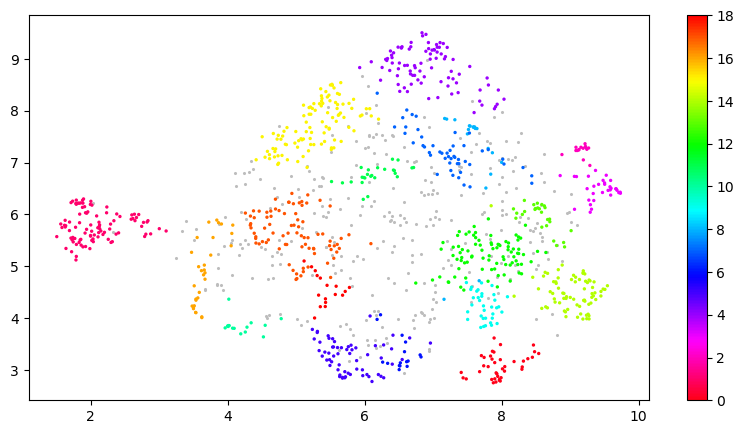

In [45]:
visualize_clusters(negative_embeddings, 15, negative_cluster)

By sorting the topics by size, we can identify which issues are the most prevalent and require immediate attention. This approach allows the customer to prioritize their efforts and address the most pressing concerns first. By understanding the most significant issues, the customer can allocate their resources efficiently and focus on improving the areas that have the greatest impact on customer satisfaction.

In [46]:
# Obtaining the top words for each topic using c-tf-idf and calculating the sizes
neg_docs_df, neg_docs_per_topic = create_docs_per_topic(df_negative, negative_cluster)
neg_tf_idf, neg_count = c_tf_idf(neg_docs_per_topic.text.values, m=len(df_negative))
neg_top_n_words = extract_top_n_words_per_topic(neg_tf_idf, neg_count, neg_docs_per_topic, n=10)
neg_topic_sizes = extract_topic_sizes(neg_docs_df); 
neg_topic_sizes.head(10)

,topic,size
0,-1,304
16,15,103
2,1,98
5,4,88
13,12,87
18,17,83
15,14,74
6,5,61
8,7,49
1,0,39


In [57]:
neg_result_df = generate_results(neg_docs_per_topic, neg_top_n_words, neg_topic_sizes)
neg_result_df

Generating resulting DataFrame may take time


,topic,size,top_words,comment_summary
0,-1,304,"[customer, tickets, time, refund, london, tick...",The online site must take money from people w...
1,0,39,"[star, stars, review, rating, follow, minus, n...",I do not understand why people are leaving ne...
2,1,98,"[eurostar, paris, brussels, customer, nord, ex...","Eurostar's ""Customer service"" has proven to b..."
3,2,15,"[wifi, fi, wi, free, scotrail, access, slow, p...",Wifi mostly didn’t work for 3 hour journey . ...
4,3,32,"[gwr, bath, seats, work, trains, comfortable, ...",New GWR 800 trains are constantly late runnin...
5,4,88,"[class, 1st, food, paid, breakfast, coffee, vi...",First western first class was amazing! The 1s...
6,5,61,"[rude, customer, poor, service, staff, terribl...",Birmingham New Street has the 'worst customer...
7,6,16,"[incompetent, company, words, organisation, la...",The Apotheosis of Human Incompetence is the w...
8,7,49,"[seats, seat, reserved, toilet, people, floor,...",Virgin trains were so overcrowded it took 30 ...
9,8,19,"[clean, toilets, smell, stink, disgusting, poo...","Every train is dirty - dirty carpets, filthy ..."


Here, we can observe that the topic modeling algorithm has successfully detected specific issues that customers have had with Eurostar, such as bad customer service, and issues with the wifi service, such as slow or unreliable connections. Furthermore, customers have expressed dissatisfaction with having to pay for wifi in addition to their ticket price, which is a significant issue that may need to be addressed by the company.

In [58]:
show_examples(neg_result_df, 3)

Company: -1
Top words: ['customer', 'tickets', 'time', 'refund', 'london', 'ticket', 'journey', 'booking', 'just', 'trains']
Comment summary:  The online site must take money from people without the phone app everyday as they chose this option for you on a continue page, misslead you by asking for your name . If you do not request refund straight away, and I don't know what if any you get back, they refund nothing even if a ticket is not used and you bough another . Cambridge to London is probably one of the worst routes they serve . Information desk worker rude and unhelpful outside platforms 1-5 (today at 19h)

Company: 0
Top words: ['star', 'stars', 'review', 'rating', 'follow', 'minus', 'national', 'just', 'better', 'score']
Comment summary:  I do not understand why people are leaving negative reviews on the National Rail page, for complaints against specific journeys and the service received from specific journey providers . National Rail are not responsible for those, only the se

### Company

Analyzing issues separated by company can help the customer save money by identifying specific areas that need improvement for each company. For instance, if one company has a bad website while the others have a good one, the customer can focus on improving the website of that particular company instead of investing money in building new websites for all the companies. This targeted approach helps optimize resources and improve efficiency in addressing issues, resulting in better customer satisfaction and potentially saving costs.

In [59]:
df_negative = df_negative.rename(columns={'url': 'topic'})
neg_company_df = df_negative.groupby(['topic'], as_index = False).agg({'text': ' '.join})
neg_company_df

,topic,text
0,arrivatrainswales,Terrible service Terrible service Overcrowded ...
1,buytickets,Very poor service Cancel trains with no explan...
2,eastmidlandstrains,Forgot our 2 together rail card Forgot our 2 t...
3,eurostar,Always a poor experience dont know if… Always ...
4,grandcentralrail,Significant decline in standards on east coast...
5,gwr,Truly terrible service in all respects 6 out o...
6,londonnorthwesternrailway,A constantly stressful experience Commuting wi...
7,nationalrail,Oh no! There is always a problem! The website ...
8,per,"Air conditioning broken, pre-ordered breakfast..."
9,southeasternrailway,Very poor service at a very high price Very po...


As with the positive comments, it appears that Virgin Trains has the most negative comments. This suggests that it is likely the most used company and, therefore, has the potential to impact the greatest number of customers.

In [60]:
neg_company_tf_idf, neg_company_count = c_tf_idf(neg_company_df.text.values, m=len(df_negative))
neg_company_top_n_words = extract_top_n_words_per_topic(neg_company_tf_idf, neg_company_count, neg_company_df, n=10)
neg_company_topic_sizes = extract_topic_sizes(df_negative) 
neg_company_topic_sizes.head(10)

,topic,size
14,virgintrains,359
10,southernrailway,238
5,gwr,168
3,eurostar,165
15,virgintrainseastcoast,99
7,nationalrail,52
1,buytickets,20
2,eastmidlandstrains,18
13,tpexpress,18
0,arrivatrainswales,17


In [61]:
neg_company_result_df = generate_results(neg_company_df, neg_company_top_n_words, neg_company_topic_sizes, company=True)
neg_company_result_df

Generating resulting DataFrame may take time


,topic,size,top_words,comment_summary
0,arrivatrainswales,17,"[arriva, board, run, wales, shrewsbury, overcr...",A train network is needed between North and S...
1,buytickets,20,"[cross, country, refund, class, travelling, pu...",Very poor service Cancel trains with no expla...
2,eastmidlandstrains,18,"[class, 33, lot, dire, drinks, leicester, team...",Virgin trains take the first class fare but d...
3,eurostar,165,"[eurostar, paris, customer, change, experience...",The advertised claim of 'change time/ date of...
4,grandcentralrail,17,"[grand, central, york, return, traveller, seat...","Grand central rail, don't do it!!! Omg on a t..."
5,gwr,168,"[gwr, paddington, app, delayed, late, cancelle...",6 out of 8 of 8 journeys either cancelled or ...
6,londonnorthwesternrailway,8,"[midland, operator, slow, sooooo, northwestern...",A nasty ammonia smell from Northampton to Lon...
7,nationalrail,52,"[national, rail, bad, platform, birmingham, si...",National rail is the worst company in Britain...
8,per,4,"[conditioning, caledonian, sleeper, falls, air...","Air conditioning broken, pre-ordered breakfas..."
9,southeasternrailway,17,"[southeastern, world, kent, timetable, leaflet...","The staff are usually good, if a bit exaspera..."


The analysis of negative comments in the dataset revealed important issues faced by customers of Virgin trains. The two most frequently mentioned issues were related to ticket refunds and overcrowding on the trains.

In [77]:
print(neg_company_result_df['top_words'][14])
print(neg_company_result_df['comment_summary'][14])

['virgin', 'class', 'ticket', 'customer', 'journey', 'trains', 'tickets', 'london', 'staff', 'refund']
 No compensation for a delay over 1 hour . Horrendous customer service and organisation at Virgin Trains, from Euston Station, from . 30/05/18 Crap Crap in every way . On the train now from London Kings Cross to Arbroath, we paid over £400 that’s including our rail cards for the 3 off is for our journey- the train was so overcrowded- we were unable to reserve a seat for our 6 hr Journey- then even the ailse were so packed with people - even outside the carriages by the toilets were full with people .


In [72]:
show_examples(neg_company_result_df, 3)

Company: arrivatrainswales
Top words: ['arriva', 'board', 'run', 'wales', 'shrewsbury', 'overcrowded', 'space', 'carriages', 'bunch', 'level']
Comment summary:  A train network is needed between North and South Wales no room for prams!! been using arriva trains for years and now i have a daughter i use trains to travel everywhere, any doctors and hospital appointments ect . Frequent occasions when the train has an inadequate number of carriages for the passengers, some of whom get left behind when no more can be crammed aboard, only to have to wait an hour for the next train . A total joke and company employs a bunch of rude and useless people .

Company: buytickets
Top words: ['cross', 'country', 'refund', 'class', 'travelling', 'pushchair', 'money', 'carriages', 'avoid', 'wifi']
Comment summary:  Very poor service Cancel trains with no explanation, always late, always overcrowded, no logic to the number of carriages allocated to services . A busy service will have 2 carriages while a

## Future Improvements

There are a few ways to make improvements in the future that could give us better insight or just help us in managing our data.

### Classifier

By building a sentiment classifier, we can further enhance our understanding of the customer feedback. With the classifier, we can analyze sentiments of comments that lack star ratings, such as those from social media platforms, providing valuable insights that would have otherwise been missed. Additionally, the classifier can help us identify sarcasm in comments where the rating and sentiment may not correspond, providing a more accurate analysis. 

To ensure the model's effectiveness, we split our dataset into train, evaluation, and test data, and selected the DistilBERT model due to its smaller size and excellent performance on small datasets.

In [40]:
# Splitting into train, evaluation, and test data
train_df, eval_df = train_test_split(df, test_size=0.3, random_state=42)
eval_df, test_df = train_test_split(eval_df, test_size=0.5, random_state=42)

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Tokenizing the data, huggingface transformers tokenizer automatically lowercase all words and as they are very robust and pretrained on a lot of data, we don't have to worry about stop words.

During the training process of our sentiment analysis model, we noticed that despite having high accuracy, the macro average F1 score was low. Upon further analysis, we discovered that the model was having difficulty differentiating between ratings other than 1 and 5. This could be attributed to the fact that the other ratings were less frequent and had similar sentiment. To address this issue, we grouped the ratings 1, 2, and 3 into a negative category and grouped the rest into a positive category. This adjustment greatly improved the model's ability to accurately identify the sentiment of the comments.

In [ ]:
# Tokenize the input text
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
eval_encodings = tokenizer(list(eval_df['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)

# Map the sentiment labels to integers
# sentiment_to_label = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
sentiment_to_label = {'1': 0, '2': 0, '3': 0, '4': 1, '5': 1}
train_labels = [sentiment_to_label[str(s)] for s in train_df['stars']]
eval_labels = [sentiment_to_label[str(s)] for s in eval_df['stars']]
test_labels = [sentiment_to_label[str(s)] for s in test_df['stars']]

# Convert the data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels))
eval_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings['input_ids']),
    torch.tensor(eval_encodings['attention_mask']),
    torch.tensor(eval_labels))
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels))




In [48]:
# Load the pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

When dealing with imbalanced data, it's important to choose the right approach to avoid losing important information. In this particular case, after exploring different approaches such as oversampling and undersampling, I found that using class weights was the most effective solution. With a significant difference in class representation, oversampling could lead to the creation of too many duplicates, while undersampling could result in a loss of valuable information. By using class weights, we can give more importance to the minority class and achieve better results in our analysis.

In [43]:
class_weights = torch.tensor(compute_class_weight('balanced', classes=[0, 1], y=train_labels)).to('cuda')
class_weights

tensor([0.5655, 4.3153], device='cuda:0', dtype=torch.float64)

In [44]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").long()
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss.float(), outputs) if return_outputs else loss.float()


In [49]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./TA_results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-5,
    evaluation_strategy='steps',
    load_best_model_at_end=True,
    save_total_limit=2,
)

# Define the trainer object
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=lambda data: {
        'input_ids': torch.stack([item[0] for item in data]),
        'attention_mask': torch.stack([item[1] for item in data]),
        'labels': torch.stack([item[2] for item in data])
    }
)


We can observe that the loss is gradually decreasing, which is a good indication that the model is effectively learning from the training data. However, after a certain point, the validation loss starts to increase, which is an indication that the model is starting to overfit the training data. To avoid overfitting, we select the best model with the lowest validation loss, which in this case is the model at 100 steps. This best model is then evaluated on the test set to ensure that it generalizes well to new data. By following this approach, we can ensure that our model is not only accurately learning from the data but also has a good ability to generalize to unseen data.

In [50]:
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.580600,0.419487
100,0.107300,0.094866
150,0.045600,0.096832


TrainOutput(global_step=150, training_loss=0.3212554756800334, metrics={'train_runtime': 230.2063, 'train_samples_per_second': 20.807, 'train_steps_per_second': 0.652, 'total_flos': 634518839562240.0, 'train_loss': 0.3212554756800334, 'epoch': 5.0})

The weighted classes approach allowed our model to correctly learn the sentiment and achieve a macro average f1 score of 0.9. This means that our model is able to accurately classify positive and negative sentiment in comments, even with imbalanced data.

In [51]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_labels
target_names = ['negative', 'positive']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    negative       0.98      0.97      0.97       181
    positive       0.79      0.88      0.83        25

    accuracy                           0.96       206
   macro avg       0.88      0.92      0.90       206
weighted avg       0.96      0.96      0.96       206



### Other Improvements

1. Instead of training a sentiment classifier, we could leverage existing sentiment analyzers such as VADER that are readily available in the nltk library.

2. An alternative approach to clustering could involve first identifying keywords in the comments and then clustering based on those keywords, rather than identifying the top words within clusters.

3. Another improvement to the current approach could be incorporating synonyms into the c-tf-idf algorithm, which may provide more accurate and comprehensive representation of the comments.

4. If we had access to more comments, we could further analyze the clusters by grouping comments within company clusters, which may provide deeper insights into company-specific issues and strengths.